In [1]:
using Random, Distributions, Plots, SparseArrays, LinearAlgebra

In [2]:
# network params
J = 6
g = 0.3
Ev = 0.5

Ne = 200
Ni = 50
N = Ne + Ni
pE = 0.2
pI = 0.8;

In [3]:
# connectivity matrix
JmatE = sprand(Bool, N, Ne, pE)
JmatE = Float64.(JmatE)
JmatE .*= (J / pE / Ne)

JmatI = sprand(Bool, N, Ni, pI)
JmatI = Float64.(JmatI)
JmatI .*= (-g * J / pI / Ni);

Jmat = sparse_hcat(JmatE, JmatI);

In [4]:
# simulation parameters
tstop = 20
dt = 0.001
tplot = collect(0:dt:tstop)
Nt = Int(tstop / dt)
E = Ev * ones(Nt, N);

In [5]:
function intensity(v, B=1, v_th=1, p=1)
    x = v .- v_th

    x[x .< 0] .= 0

    B .* x.^p
end

intensity (generic function with 4 methods)

In [6]:
# initial params
v = zeros(Nt, N) # voltage
v[1,:] = rand(N)
v_th = 1
v_r = 0
n = zeros(Nt, N) # spikes
spkind = []

# perturbations
perturb_amp = 2
perturb_len = 2

t_start_perturb1 = Int(Nt / 4)
t_end_perturb1 = t_start_perturb1 + Int(perturb_len / dt)

t_start_perturb2 = 3 * t_start_perturb1
t_end_perturb2 = t_start_perturb2 + Int(perturb_len / dt)

E[t_start_perturb1:t_end_perturb1,:] .+= perturb_amp
E[t_start_perturb2:t_end_perturb2,:] .-= perturb_amp;

In [7]:
for t = 2:Nt
    v[t,:] .= v[t-1,:] .+ (dt .* (-v[t-1,:] .+ E[t-1,:])) .+ (Jmat * n[t-1,:])
    v[t,spkind] .= v_r

    lam = intensity(v[t,:])
    lam[lam .> (1/dt)] .= 1 / dt

    n[t,:] = rand.(Bernoulli.(dt .* lam))

    spkind = findall(n[t,:] .> 0)
end

spkind_all = findall(n .> 0)
st,sni = dt .* getindex.(spkind_all,1), getindex.(spkind_all,2);

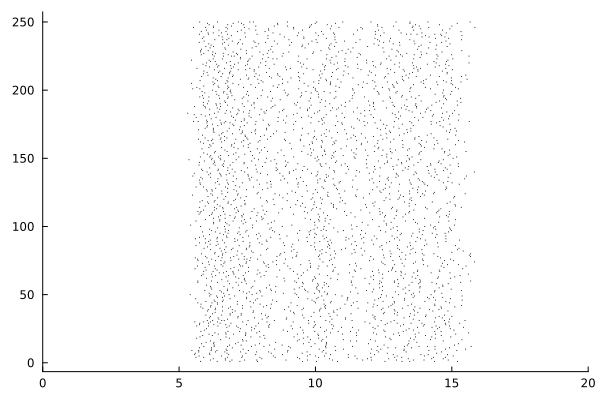

In [8]:
plot(st, sni,
     seriestype = :scatter,
     markershape = :vline,
     color = :black,
     markersize = 0.5,
     legend = false,
     grid = false)

xlims!(0, 20)

In [9]:
using ProgressMeter

In [10]:
function sim_lif_syncurr(J, E, g_l, c_m, g_ext, g_rec, tau_recep, Vc, EI_ratio, In_sens, bg_spks, tstop, dt, v_th, v_r)
    Nt = Int(tstop / dt) # time points
    N = size(J, 1)
    E0 = length(E) == 1 ? fill(E, N) : E

    println("Simulating network of $(length(E0)) neurons")

    Ne,Ni = EI_ratio

    v = zeros(Nt,N)
    v[1,:] .= E0 # starting voltage

    C = zeros(N)
    C[1:Ne] .= c_m["e"]
    C[Ne+1:end] .= c_m["i"]

    g_L = zeros(N)
    g_L[1:Ne] .= g_l["e"]
    g_L[Ne+1:end] .= g_l["i"]

    I_syn = zeros(Nt, N)
    I_ext_ampa = zeros(Nt, N)
    I_ampa = zeros(Nt, N)
    I_nmda = zeros(Nt, N)
    I_gaba = zeros(Nt, N)

    g_ext_ampa = zeros(N)
    g_ext_ampa[1:Ne] .= g_ext["ampa_e"]
    g_ext_ampa[Ne+1:end] .= g_ext["ampa_i"]

    g_ampa = zeros(N)
    g_ampa[1:Ne] .= g_rec["ampa_e"]
    g_ampa[Ne+1:end] .= g_rec["ampa_i"]

    g_nmda = zeros(N)
    g_nmda[1:Ne] .= g_rec["nmda_e"]
    g_nmda[Ne+1:end] .= g_rec["nmda_i"]

    g_gaba = zeros(N)
    g_gaba[1:Ne] .= g_rec["gaba_e"]
    g_gaba[Ne+1:end] .= g_rec["gaba_i"]

    s_ext_ampa = zeros(Nt, N)
    s_ampa = zeros(Nt, Ne)
    s_nmda = zeros(Nt, Ne)
    s_gaba = zeros(Nt, Ni)
    x = zeros(Nt, Ne)

    tau_ampa = tau_recep["ampa"]
    tau_nmda_rise = tau_recep["nmda_rise"]
    tau_nmda_decay = tau_recep["nmda_decay"]
    tau_gaba = tau_recep["gaba"]

    Ve = Vc["e"]
    Vi = Vc["i"]

    E = copy(E0)
    n = zeros(Nt, N)

    @showprogress for t in 2:Nt
        v[t, :] = v[t-1, :] .+ (dt ./ C) .* (-g_L .* (v[t-1, :] .- E) .- I_syn[t-1, :])
        spkind = findall(x -> x ≥ v_th, v[t, :])
        n[t, spkind] .= 1

        s_ext_ampa[t, :] = s_ext_ampa[t-1, :] .+ dt .* (-s_ext_ampa[t-1, :] ./ tau_ampa) .+ bg_spks[t-1, :] .+ In_sens[t-1, :]
        s_ampa[t, :] = s_ampa[t-1, :] .+ dt .* (-s_ampa[t-1, :] ./ tau_ampa) .+ n[t, 1:Ne]
        x[t, :] = x[t-1, :] .+ dt .* (-x[t-1, :] ./ tau_nmda_rise) .+ n[t, 1:Ne]
        s_nmda[t, :] = s_nmda[t-1, :] .+ dt .* (-s_nmda[t-1, :] ./ tau_nmda_decay .+ 500 .* x[t-1, :] .* (1 .- s_nmda[t-1, :]))
        s_gaba[t, :] = s_gaba[t-1, :] .+ dt .* (-s_gaba[t-1, :] ./ tau_gaba) .+ n[t, Ne+1:end]

        I_ext_ampa[t, :] = g_ext_ampa .* (v[t, :] .- Ve) .* s_ext_ampa[t, :]
        I_ampa[t, :] = g_ampa .* (v[t, :] .- Ve) .* (J[:, 1:Ne] * s_ampa[t, :])
        I_nmda[t, :] = (g_nmda .* (v[t, :] .- Ve)) ./ (1 .+ exp.(-0.062 .* v[t, :]) ./ 3.57) .* (J[:, 1:Ne] * s_nmda[t, :])
        I_gaba[t, :] = g_gaba .* (v[t, :] .- Vi) .* (J[:, Ne+1:end] * s_gaba[t, :])
        I_syn[t, :] = I_ext_ampa[t, :] .+ I_ampa[t, :] .+ I_nmda[t, :] .+ I_gaba[t, :]

        v[t, spkind] .= v_r # voltage reset
    end

    spktimes = [Float64[t*dt, i] for t in 1:Nt, i in 1:N if n[t,i] == 1]

    gating_vars = Dict(
        "ext_ampa" => s_ext_ampa,
        "ampa" => s_ampa,
        "nmda" => s_nmda,
        "gaba" => s_gaba
    )

    syn_currents = Dict(
        "total" => I_syn,
        "ext_ampa" => I_ext_ampa,
        "ampa" => I_ampa,
        "nmda" => I_nmda,
        "gaba" => I_gaba
    )

    return v, spktimes, n, syn_currents, gating_vars

end     

sim_lif_syncurr (generic function with 1 method)

In [ ]:
function sim_lif_syncurr_opt(J, E, g_l, c_m, g_ext, g_rec, tau_recep, Vc, EI_ratio, In_sens, bg_spks, tstop, dt, v_th, v_r)
    Nt = Int(tstop / dt)
    N = size(J, 1)
    Ne, Ni = EI_ratio

    v = Matrix{Float32}(undef, Nt, N)
    v[1, :] .= E

    C = fill(0f0, N)
    C[1:Ne] .= c_m["e"]
    C[Ne+1:end] .= c_m["i"]

    g_L = fill(0f0, N)
    g_L[1:Ne] .= g_l["e"]
    g_L[Ne+1:end] .= g_l["i"]

    I_syn = zeros(Float32, Nt, N)
    I_ext_ampa = similar(I_syn)
    I_ampa = similar(I_syn)
    I_nmda = similar(I_syn)
    I_gaba = similar(I_syn)

    g_ext_ampa = fill(0f0, N)
    g_ext_ampa[1:Ne] .= g_ext["ampa_e"]
    g_ext_ampa[Ne+1:end] .= g_ext["ampa_i"]

    g_ampa = fill(0f0, N)
    g_ampa[1:Ne] .= g_rec["ampa_e"]
    g_ampa[Ne+1:end] .= g_rec["ampa_i"]

    g_nmda = fill(0f0, N)
    g_nmda[1:Ne] .= g_rec["nmda_e"]
    g_nmda[Ne+1:end] .= g_rec["nmda_i"]

    g_gaba = fill(0f0, N)
    g_gaba[1:Ne] .= g_rec["gaba_e"]
    g_gaba[Ne+1:end] .= g_rec["gaba_i"]

    s_ext_ampa = zeros(Float32, Nt, N)
    s_ampa = zeros(Float32, Nt, Ne)
    s_nmda = zeros(Float32, Nt, Ne)
    s_gaba = zeros(Float32, Nt, Ni)
    x = zeros(Float32, Nt, Ne)

    tau_ampa = tau_recep["ampa"]
    tau_nmda_rise = tau_recep["nmda_rise"]
    tau_nmda_decay = tau_recep["nmda_decay"]
    tau_gaba = tau_recep["gaba"]

    Ve, Vi = Vc["e"], Vc["i"]
    n = zeros(UInt8, Nt, N)  # UInt8 to reduce memory
    tmp_ampa = zeros(Float32, N)
    tmp_nmda = zeros(Float32, N)
    tmp_gaba = zeros(Float32, N)

    @inbounds @simd for t = 2:Nt
        v_prev = @view v[t - 1, :]
        v_curr = @view v[t, :]
        I_prev = @view I_syn[t - 1, :]

        @. v_curr = v_prev + (dt / C) * (-g_L * (v_prev - E) - I_prev)

        # Spike detection
        spkind = v_curr .≥ v_th
        n[t, :] .= spkind

        # Synaptic dynamics
        @views begin
            s_ext_ampa[t, :] .= s_ext_ampa[t-1, :] .+ dt .* (-s_ext_ampa[t-1, :] ./ tau_ampa) .+ bg_spks[t-1, :] .+ In_sens[t-1, :]
            s_ampa[t, :] .= s_ampa[t-1, :] .+ dt .* (-s_ampa[t-1, :] ./ tau_ampa) .+ n[t, 1:Ne]
            x[t, :] .= x[t-1, :] .+ dt .* (-x[t-1, :] ./ tau_nmda_rise) .+ n[t, 1:Ne]
            s_nmda[t, :] .= s_nmda[t-1, :] .+ dt .* (-s_nmda[t-1, :] ./ tau_nmda_decay .+ 500 .* x[t-1, :] .* (1 .- s_nmda[t-1, :]))
            s_gaba[t, :] .= s_gaba[t-1, :] .+ dt .* (-s_gaba[t-1, :] ./ tau_gaba) .+ n[t, Ne+1:end]
        end

        v_now = @view v[t, :]
        tmp_ampa .= J[:, 1:Ne] * s_ampa[t, :]
        tmp_nmda .= J[:, 1:Ne] * s_nmda[t, :]
        tmp_gaba .= J[:, Ne+1:end] * s_gaba[t, :]

        @. I_ext_ampa[t, :] = g_ext_ampa * (v_now - Ve) * s_ext_ampa[t, :]
        @. I_ampa[t, :] = g_ampa * (v_now - Ve) * tmp_ampa
        @. I_nmda[t, :] = (g_nmda * (v_now - Ve)) / (1 + exp(-0.062 * v_now) / 3.57) * tmp_nmda
        @. I_gaba[t, :] = g_gaba * (v_now - Vi) * tmp_gaba

        @. I_syn[t, :] = I_ext_ampa[t, :] + I_ampa[t, :] + I_nmda[t, :] + I_gaba[t, :]

        # Voltage reset
        @. v[t, :] = ifelse(spkind, v_r, v[t, :])
    end

    spktimes = [Float64[t*dt, i] for t in 1:Nt, i in 1:N if n[t,i] == 1]

    return v, spktimes, n, Dict(
        "total" => I_syn,
        "ext_ampa" => I_ext_ampa,
        "ampa" => I_ampa,
        "nmda" => I_nmda,
        "gaba" => I_gaba,
    ), Dict(
        "ext_ampa" => s_ext_ampa,
        "ampa" => s_ampa,
        "nmda" => s_nmda,
        "gaba" => s_gaba,
    )
end

LoadError: LoadError: Base.SimdLoop.SimdError("for loop expected")
in expression starting at c:\Users\Mateo\Documents\BU\ocker group\lif_stochastic_decision\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X13sZmlsZQ==.jl:56

In [12]:
function create_connect_mat(Ne::Int, Ni::Int, f::Float64, wstrong::Float64)
    N = Ne + Ni
    wweak = 1 - ((f * (wstrong - 1)) / (1 - f))
    fNe = Int(f * Ne)

    Jmat = zeros(Float64, N, N)

    # All excitatory to all others: weight 1
    Jmat[:, 1:Ne] .= 1.0

    # Selective A to A and B to B: weight wstrong
    Jmat[1:fNe, 1:fNe] .= wstrong
    Jmat[fNe+1:2*fNe, fNe+1:2*fNe] .= wstrong

    # Selective A to B and B to A: weight wweak
    Jmat[fNe+1:2*fNe, 1:fNe] .= wweak
    Jmat[1:fNe, fNe+1:2*fNe] .= wweak

    # Nonselective to selective: weight wweak
    Jmat[1:2*fNe, 2*fNe+1:Ne] .= wweak

    # Inhibitory to all: weight 1
    Jmat[:, Ne+1:end] .= 1.0

    return Jmat
end

create_connect_mat (generic function with 1 method)

In [13]:
function gen_sensory_stim(; 
    mu_0::Float64 = 20.0, 
    sigma::Float64 = 4.0, 
    dt::Float64, 
    rho = nothing, 
    coh::Float64 = 0.0, 
    f::Float64 = 0.15, 
    N::Int = 2000, 
    sim_len::Float64 = 4.0, 
    stim_len::Float64 = 0.5, 
    t_start::Float64 = 1.0
)
    # Decode rho input
    if rho !== nothing && length(rho) > 0
        rho_A, rho_B = rho
    else
        rho_A = mu_0 / 100
        rho_B = mu_0 / 100
    end

    mu_A = mu_0 + rho_A * coh
    mu_B = mu_0 - rho_B * coh

    fNe = Int(f * N * 0.8)  # number of selective neurons
    fNe2 = 2 * fNe

    Nt = Int(sim_len / dt)  # total time points
    switch_idx = Int(0.05 / dt)  # every 50 ms
    num_switches = Int((stim_len / dt) / switch_idx)

    stim_A_rate_list = randn(num_switches) .* sigma .+ mu_A
    stim_B_rate_list = randn(num_switches) .* sigma .+ mu_B

    stim_spikes = zeros(Float64, Nt, N)

    for i in 1:num_switches
        swi = Int((i - 1) * switch_idx + (t_start / dt))

        stim_spikes[swi:swi+switch_idx-1, 1:fNe] .= 
            (rand(switch_idx, fNe) .< stim_A_rate_list[i] * dt) .* 1.0
        stim_spikes[swi:swi+switch_idx-1, fNe+1:fNe2] .= 
            (rand(switch_idx, fNe) .< stim_B_rate_list[i] * dt) .* 1.0
    end

    return stim_spikes
end

gen_sensory_stim (generic function with 1 method)

In [14]:
function gen_bg_noise(rate::Float64, dt::Float64, N::Int, sim_len::Float64)
    Nt = Int(sim_len / dt)
    spks = (rand(Nt, N) .< (rate * dt)) .* 1.0
    return spks
end

gen_bg_noise (generic function with 1 method)

### Params

In [15]:
E = -70
v_th = -50
v_r = -55

Ne = 1600
Ni = 400
EI_ratio = (Ne, Ni)
N = Ne + Ni
f = 0.15
wstrong = 1.7

tstop = 4.0
dt = 0.0001
tplot = 0:dt:(tstop - dt)

g_l = Dict("e" => 25, "i" => 20)
c_m = Dict("e" => 0.5, "i" => 0.2)

g_ext = Dict("ampa_e" => 2.1, "ampa_i" => 1.62) # external input conducatance
g_rec = Dict("ampa_e" => 0.05, "nmda_e" => 0.165, "gaba_e" => 1.3,
         "ampa_i" => 0.04, "nmda_i" => 0.13, "gaba_i" => 1.0) # recurrent conductances

tau_recep = Dict("ampa" => 0.002, "nmda_rise" => 0.002, "nmda_decay" => 0.100, "gaba" => 0.005)

Vc = Dict("e" => 0, "i" => -70); # E/I target voltages

In [16]:
Jmat = create_connect_mat(Ne, Ni, f, wstrong);

### Simulation params

In [17]:
mu_0 = 40.0
coh = 51.2
stim_len = 2.0
stim_spikes = gen_sensory_stim(mu_0=mu_0, dt=dt, coh=coh, stim_len=stim_len);

In [18]:
bg_rate = 2400.0

bg_spks = gen_bg_noise(bg_rate, dt, N, tstop);

In [19]:
v, spktimes, spktrains, syn_currents, gating_vars = sim_lif_syncurr_opt(Jmat, E, g_l, c_m, g_ext, g_rec, tau_recep, Vc, EI_ratio, stim_spikes, bg_spks, tstop, dt, v_th, v_r)

(Float32[-70.0 -70.0 … -70.0 -70.0; -70.0 -70.0 … -70.0 -70.0; … ; -52.950207 -52.398434 … -51.614174 -53.99778; -52.912804 -52.395187 … -51.66716 -54.025867], [[0.8736, 1.0], [1.2198, 1.0], [1.2518, 1.0], [1.2839, 1.0], [1.2935, 1.0], [1.318, 1.0], [1.3293000000000001, 1.0], [1.3523, 1.0], [1.3673, 1.0], [1.3861, 1.0]  …  [3.0574000000000003, 2000.0], [3.2818, 2000.0], [3.2928, 2000.0], [3.4296, 2000.0], [3.4847, 2000.0], [3.7271, 2000.0], [3.8150000000000004, 2000.0], [3.8778, 2000.0], [3.9308, 2000.0], [3.9898000000000002, 2000.0]], UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00], Dict{String, Matrix{Float32}}("total" => [0.0 0.0 … 0.0 0.0; -147.0 0.0 … 0.0 0.0; … ; -613.2657 -456.26343 … -261.746 -263.8712; -686.38116 -426.1665 … -321.66974 -242.25003], "gaba" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 522.33344 539.2374 … 433.27988 377.10788; 535.2231 551.4364 … 441.72345 384.8912], "nmda" => [0.0 0.0 … 0.0 0.0; -0.0 -0.0 … 

In [20]:
v2, spktimes2, spktrains2, syn_currents2, gating_vars2 = v, spktimes, spktrains, syn_currents, gating_vars = sim_lif_syncurr_opt(Jmat, E, g_l, c_m, g_ext, g_rec, tau_recep, Vc, EI_ratio, stim_spikes, bg_spks, tstop, dt, v_th, v_r)

(Float32[-70.0 -70.0 … -70.0 -70.0; -70.0 -70.0 … -70.0 -70.0; … ; -52.950207 -52.398434 … -51.614174 -53.99778; -52.912804 -52.395187 … -51.66716 -54.025867], [[0.8736, 1.0], [1.2198, 1.0], [1.2518, 1.0], [1.2839, 1.0], [1.2935, 1.0], [1.318, 1.0], [1.3293000000000001, 1.0], [1.3523, 1.0], [1.3673, 1.0], [1.3861, 1.0]  …  [3.0574000000000003, 2000.0], [3.2818, 2000.0], [3.2928, 2000.0], [3.4296, 2000.0], [3.4847, 2000.0], [3.7271, 2000.0], [3.8150000000000004, 2000.0], [3.8778, 2000.0], [3.9308, 2000.0], [3.9898000000000002, 2000.0]], UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00], Dict{String, Matrix{Float32}}("total" => [0.0 0.0 … 0.0 0.0; -147.0 0.0 … 0.0 0.0; … ; -613.2657 -456.26343 … -261.746 -263.8712; -686.38116 -426.1665 … -321.66974 -242.25003], "gaba" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 522.33344 539.2374 … 433.27988 377.10788; 535.2231 551.4364 … 441.72345 384.8912], "nmda" => [0.0 0.0 … 0.0 0.0; -0.0 -0.0 … 